# Ensemble Forecast Adjustment Demonstration

Luke Madaus, University of Washington, January 2016

This iPython notebook demonstrates the Ensemble Forecast Adjustment technique (Madaus and Hakim 2015; QJRMS) for updating ensemble forecast trajectories with assimilated observations. Here we use a sample of the GEFS ensemble forecast of surface temperature with dummy observations to show how this technique works in an interactive way.

First, we'll start by importing a variety of libraries we will be using.

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
from IPython.display import display
from ipywidgets import widgets, interact
from copy import deepcopy
from random import shuffle
%matplotlib inline

## Acquiring background information

Now, we need to get an ensemble forecast we want to update.  Here we're using the Unidata Siphon library (https://github.com/Unidata/siphon; easily installed using "pip install siphon") to download the latest GFS Ensemble forecast (GEFS) for a single point.  The function below does this.

In [2]:
def get_ensemble_point(point, variables=['Temperature_height_above_ground_ens'], start=datetime.utcnow()-timedelta(hours=12), end=datetime.utcnow()+timedelta(hours=48)):
    """
    Retrieves the latest ("best") ensemble forecast valid at a single point from the Unidata THREDDS server using
    the Unidata siphon library.
    
    Requires:
    point -> A tuple of (lat, lon) of the point we are trying to retrieve
    variables -> A list of variables we want to retrieve.  Check this page for a full list:
            http://thredds.ucar.edu/thredds/metadata/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/Best?metadata=variableMap
    start -> A datetime object of the earliest time to look for an ensemble initialization,
            default is current time minus 12 hours
    end -> The last time for which we want ensemble forecast output.  Default is current time plus 48 hours.
    
    Returns:
    A dictionary with one item being the list of valid times in the data ('times') and the rest of the items
    being numpy arrays of nTimes x nEnsmems for each variable requested
        
    """
    # Import the Siphon utilities 
    from siphon.catalog import TDSCatalog
    from siphon.ncss import NCSS
    
    # In Siphon, we connect to a thredds catalog.  Here's the address for the GEFS
    catalog = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/catalog.xml' 
    best_model = TDSCatalog(catalog)
    
    # We select a specific dataset in this catalog, in this case the "best" (most recent) ensemble run 
    best_ds = list(best_model.datasets.values())[2]
    ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

    
    
    # Here we format our subsetting query.  We specify the exact point we want,
    # the time range, and the variables we are requesting.  We're also going
    # to retrieve the data in a netcdf-like format
    query = ncss.query()
    query.lonlat_point(point[1], point[0])
    query.time_range(start, end)
    query.variables(*variables)
    query.accept('netcdf')

    # Actually get the data
    data = ncss.get_data(query)
    
    # Format our output into a dictionary
    output = {}
    for v in variables:
        # After the squeeze, this is a nTimes x nEns array
        output[v] = np.squeeze(data.variables[v][:])
        #print output[v].shape
    # Also, add times
    # The 'time' variable is hours since "time_coverage_start"
    # Get this in datetime format
    raw_hours = list(np.squeeze(data.variables['time'][:]))
    init_time = datetime.strptime(str(data.time_coverage_start), '%Y-%m-%dT%H:%M:%SZ')
    output['times'] = [init_time + timedelta(hours=int(x)) for x in raw_hours]
    
    # Return a dictionary
    return output
    
    

We use the above function to request the ensemble forecast of surface temperature ('Temperature_height_above_ground_ens') for a point (here, Sea-Tac airport).  For now, we're also going to set some dummy observations that correspond to the first several valid times in the ensemble output.

In [67]:
# This returns a dictionary of the ensemble forecast
ensemble = get_ensemble_point((47.4489, -122.3094), ['Temperature_height_above_ground_ens'])

# One observation value (in Kelvin) for each of the first
# five valid times in the ensemble output
obs = [275., 275., 275.0, 275.0, 276.0]
#obs = [278.7, 280.0]

## The Assimilation

We have the background ensemble and observations, so now we can try assimilating them.  Below we define a function called "enkf" that implments an ensemble square-root filter version of the Kalman filter.

In [68]:
def enkf(obs, prior, obs_range=(1,2), ob_error=1.0, inflation=1.0):
    """
    Updates a prior ensemble given a selection of obs.
    
    Currently assumes that there is only one state variable and each observation
    corresponds with successive times in that variable, starting at the beginning
    of the ensemble state.
    
    Requires:
    obs -> A list of observation values, each corresponding to a successive time in the forecast
            and starting at the first valid time.
    prior -> A nTimes x nEnsMems array of the state variable
    obs_range -> Tuple (start, end) of which subset of observations to assimilate.  
                In the list of observations, will use the subset from (start:end)
    ob_error -> The error variance to use for the observations in units^2
    inflation -> A simple multiplicative inflation factor to inflate the background ensemble covariances.
                Default is 1.0
    
    Returns:
        A nTimes x nEnsMems array of the prior updated by the observations (the posterior)
    
    """
    
    # Figure out the size of our state and ensemble members
    Nstate, Nens = prior.shape
    # Filter based on obs range
    obs = obs[obs_range[0]-1:obs_range[-1]]
    #print obs, obs_range
    post = deepcopy(prior)
    
    # Compute prior and posterior mean and perturbations
    prior_mean = np.mean(prior, axis=1)
    post_mean = np.mean(post, axis=1)
    prior_pert = prior - prior_mean[:,None]
    post_pert = post - post_mean[:,None]
    
    # Inflate the ensemble?
    prior_pert *= inflation
    post_pert *= inflation
    
    # For now we assume that the indices of the obs we are
    # assimilating match up with indices in the state array
    # Randomize the order of the observations every time
    obdexes = xrange(len(obs))
    obzip = zip(obdexes, obs)
    shuffle(obzip)
    
    # Serial assimilation (no localization here, so this should be ok...)
    for obval in obzip:
        obnum, ob = obval
        #print obnum, ob, obs_range[0]
        ob_index = obs_range[0] + obnum -1
        prior_mean = post_mean
        prior_pert = post_pert
        # Build H
        H = np.zeros(Nstate)
        H[ob_index] = 1.0
        #print "H:", H
        # Get estimate of ob (ye or HXb)
        ye = np.dot(H, np.add(prior_pert, prior_mean[:,None]))
        # Ensemble mean of ye
        ye_mean = np.mean(ye)
        # And variance in Ye
        ye_variance = np.var(ye - ye_mean)
        
       
        
        # Compute innovation (y-HXb)
        innov = ob - ye_mean
        #print "Obnum:", obnum, "  Innov:", innov,
        #print " Obval:", ob, "  ye:", ye_mean
        # Now the numerator of the Kalman gain--covariance between
        # ensemble state and the ensemble estimate of the ob
        kcov = np.dot(prior_pert, ye) / (Nens-1)
              
        # Compute the Kalman gain
        K = np.divide(kcov, (ye_variance + ob_error))
        #print K
        
        # Now update the mean -> x_post = x_prior + K * innovation
        post_mean = prior_mean + np.multiply(K, innov)
        
        # Compute the square-root factor to account for sampling error
        beta = 1.0 / (1.0 + np.sqrt(ob_error/(ye_variance + ob_error)))
        
        # Now update the perturbation
        #print K.shape
        #print ye.shape
        #print prior_pert.shape
        post_pert = prior_pert - np.dot((beta * K)[:,None], (ye-ye_mean)[None, :])

    # Return the full posterior state (mean + pert)
    return post_pert + post_mean[:,None]

## Viewing the results

The function below builds a matplotlib plot to show the ensemble state before and after assimilation, as well as the ensemble variance.  It uses iPython "widgets" to allow various parameters to be changed, namely the number of observations assimilated, the observation error variance and the inflation factor.

In [71]:
def assimilation_viewer(obs_range, ob_error, inflation, show_inflated):
    # On calling the function, do the assimilation with the specified parameters
    # Grab the prior state from the dictionary
    prior = ensemble['Temperature_height_above_ground_ens']
    prior_mean = np.mean(prior, axis=1)
    prior_pert = prior - prior_mean[:, None]
    
    post = enkf(obs, prior, obs_range=obs_range, ob_error=ob_error, inflation=inflation)
    post_mean = np.mean(post, axis=1)
    
    # Figure out if we're plotting inflated prior or not
    if show_inflated:
        prior_pert *= inflation
        prior = prior_pert + prior_mean[:,None]
    
    # Set up the figure
    plt.figure(figsize=(12,10))
    # Top panel will be a "spaghetti plot" of the prior and posterior ensemble trajectories
    ax = plt.subplot(2,1,1)
    ax.plot(ensemble['times'], prior, c='LightSlateGrey', alpha=0.3)
    ax.plot(ensemble['times'], post, c='Tomato', alpha=0.3)
    ax.plot(ensemble['times'], prior_mean, c='LightSlateGrey', alpha=1.0, lw=2)
    ax.plot(ensemble['times'], post_mean, c='Tomato', alpha=1.0, lw=2)
    # Also, plot the observations we assimilated (Subsetting if obs_range has been changed)
    ax.scatter(ensemble['times'][obs_range[0]-1:obs_range[-1]], obs[obs_range[0]-1:obs_range[-1]], c='k', s=60)
    # Various titles, labels and prettifications...
    ax.set_title('EFA Adjustment of Temperature Trajectory', fontsize=14)
    ax.set_ylabel('Temperature [K]', fontsize=12)
    ax.set_xlabel('Valid Time', fontsize=12)
    ax.set_xlim((matplotlib.dates.date2num(ensemble['times'][0]), matplotlib.dates.date2num(ensemble['times'][-1])))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d/%HZ'))
    ax.grid()
    
    # Plot the ensemble prior and posterior variance
    ax2 = plt.subplot(2,1,2)   
    prior_var = np.var(prior - np.mean(prior,axis=1)[:,None], axis=1)
    post_var = np.var(post - np.mean(post,axis=1)[:,None], axis=1)
    ax2.plot(ensemble['times'], prior_var, lw=2, c='LightSlateGrey', label='Prior')
    ax2.plot(ensemble['times'], post_var, lw=2, c='Tomato', label='Post')
    # Remind us of the inflation
    ax2.text(0.14,0.93,'Inflation: {:2.1f}'.format(inflation), fontsize=14, transform=ax2.transAxes, ha='left', va='center')
    # More prettifications...
    ax2.set_xlabel('Valid Time', fontsize=12)
    ax2.set_xlim((matplotlib.dates.date2num(ensemble['times'][0]), matplotlib.dates.date2num(ensemble['times'][-1])))
    ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d/%HZ'))
    ax2.set_ylabel('Ens. Variance [K$^{2}$]', fontsize=12)
    ax2.legend(loc=0)  
    ax2.grid()
    
# This uses iPython widgets to build sliders for determining what to assimilate
obs_slider = widgets.IntRangeSlider(min=1, max=len(obs), step=1, value=(1, len(obs)), description='Num. Obs. Assimilated')
error_slider = widgets.FloatSlider(value=1.0, min=0.25, max=2.0, step=0.25, description='Obs. Error [K$^{2}$]')
inflation_slider = widgets.FloatSlider(value=1.0, min=1.0, max=3.0, step=0.5, description='Inflation Factor')
show_inflated_prior = widgets.Checkbox(description="Show inflated prior", value=False)

With the image generation function built and the sliders defined, we can display our interactive image.  

Try experimenting with decreasing the observation error to see how that places more weight on the observations.  Or, similarly, increase the inflation factor to weight the observations more.

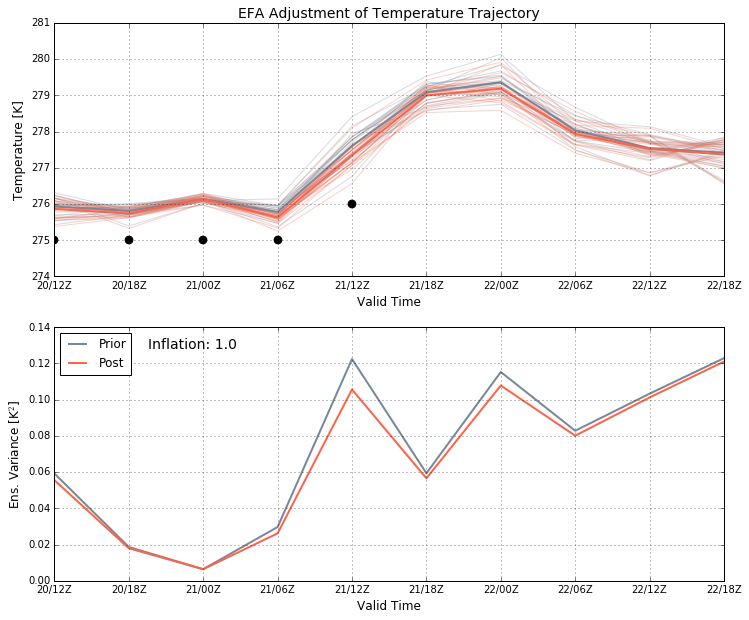

In [72]:
w = widgets.interactive(assimilation_viewer, obs_range=obs_slider, ob_error=error_slider, inflation=inflation_slider, show_inflated=show_inflated_prior)  
display(w)